In [25]:
import nd2reader
import tifffile as tiff

# Path to the .nd2 files
image_path = glob.glob('/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/small/*.nd2')
output_path = '/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/small/'

for i,p in enumerate(image_path ):
    nd2_file_path = p

    # Load the .nd2 file
    nd2 = nd2reader.ND2Reader(nd2_file_path)

    # Extract metadata to find out how many channels there are
    # This depends on the nd2reader version; if this doesn't work, consult the specific version's documentation
    metadata = nd2.metadata

    # Get the number of channels
    num_channels = len(metadata['channels'])

    # Loop through each channel and save the images
    for i in range(num_channels):
        # Assuming we are only dealing with a single frame and single z-level
        # Adjust the code here if you have multiple frames or z-levels
        images = nd2.get_frame_2D(c=i)

        # Save the images
        tiff.imwrite(output_path + p.split('/')[-1].split('.')[0] +f'_channel_{i}.tif', images)

    # Close the nd2 file
    nd2.close()

In [27]:
# Create Mask from Dapi nuclei

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

image_path = glob.glob('/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/small/*channel_0.tif')
output_path = '/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/small/mask/'

for i,p in enumerate(image_path ):
    # Load the DAPI image (grayscale)
    dapi_image_path = p
    dapi_image = cv2.imread(dapi_image_path, cv2.IMREAD_GRAYSCALE)

    # Preprocess the image (e.g., Gaussian blur to reduce noise)
    preprocessed_image = cv2.GaussianBlur(dapi_image, (5, 5), 0)

    # Threshold the image to get a binary mask
    # Otsu's method automatically determines an optimal threshold value
    ret, binary_mask = cv2.threshold(preprocessed_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Post-processing to remove small objects (noise)
    # Find contours (similar to labeling)
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask to draw the contours on
    mask = np.zeros_like(dapi_image)

    # Draw the contours on the mask
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

    # Optional: Filter by contour area to remove small objects
    min_area = 1
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    mask_filtered = np.zeros_like(dapi_image)
    cv2.drawContours(mask_filtered, filtered_contours, -1, (255), thickness=cv2.FILLED)

    # Save the filtered mask as a .tif image
    filtered_mask_path = output_path + 'mask_'+ p.split('/')[-1]

    cv2.imwrite(filtered_mask_path, mask_filtered)

#     # Show the original and the mask
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     ax[0].imshow(dapi_image, cmap='gray')
#     ax[0].set_title('Original DAPI Image')
#     ax[0].axis('off')

#     ax[1].imshow(mask_filtered, cmap='gray')
#     ax[1].set_title('Mask of Nuclei')
#     ax[1].axis('off')

#     plt.show()


In [50]:
# Use Mask on IF

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to assign colony based on label (this is a dummy function)
def assign_colony(label):
    # Replace this with actual logic to assign a colony
    return "Colony_" + str(label % 5)  # Example logic

# List to keep track of cell information
cells_info = []

image_path = glob.glob('/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/*_channel_0.tif')
output_path = '/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/'

for i,p in enumerate(image_path ):

    # Load the DAPI image (grayscale)
    dapi_image_path = p
    dapi_image = cv2.imread(dapi_image_path, cv2.IMREAD_GRAYSCALE)

    # Preprocess the image (e.g., Gaussian blur to reduce noise)
    preprocessed_image = cv2.GaussianBlur(dapi_image, (5, 5), 0)

    # Threshold the image to get a binary mask
    # Otsu's method automatically determines an optimal threshold value
    ret, binary_mask = cv2.threshold(preprocessed_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find connected components (unique IDs for each nucleus)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)


    # Convert labels_im to 8-bit image
    labels_im_8bit = np.uint8(labels_im)

    # Expand the mask to include some cytoplasm
    # Define the kernel size for dilation. The size of the kernel affects how much the mask will expand.
    kernel_size = 8  # This value can be adjusted depending on how much you want to expand the mask.
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    expanded_masks = cv2.dilate(labels_im_8bit, kernel, iterations=1)


    # Create an RGB image with the red channel set to the mask and the others to black
    red_mask = np.zeros_like(dapi_image)
    red_mask[expanded_masks > 0] = 255  # Set nuclei to red
    red_mask_rgb = np.stack((red_mask, np.zeros_like(red_mask), np.zeros_like(red_mask)), axis=2)

    # Overlay the red mask on the original image
    alpha = 0.2  # Transparency factor for the mask
    overlayed_img = cv2.addWeighted(red_mask_rgb, alpha, cv2.cvtColor(dapi_image*10, cv2.COLOR_GRAY2BGR), 1 - alpha, 0)



    # Visualize the result
    plt.imshow(overlayed_img)
    plt.title('Overlayed Nuclei Mask on Original DAPI Image')
    plt.axis('off')
    # Save the figure
    filtered_mask_path = output_path +'mask_expanded/'+ 'mask_expanded'+ p.split('/')[-1].split('.')[0] +'.png'
    plt.savefig(filtered_mask_path, bbox_inches='tight')
    
    # Save the filtered mask as a .tif image
    filtered_mask_path = output_path +'mask_expanded/'+ 'mask_expanded_'+ p.split('/')[-1]
    cv2.imwrite(filtered_mask_path, expanded_masks)

    # If you no longer need the plot in memory, you can close it with plt.close()
    plt.close()
    
    
    
    # Load channel 1 image (grayscale)
    channel1_image_path = p.split('_channel_')[0] + '_channel_1.tif' 
    
    channel2_image_path = p.split('_channel_')[0] + '_channel_2.tif' 
    
    print(p)
    print(channel1_image_path )
    print(channel2_image_path )
    print('--------')
    channel1_image = cv2.imread(channel1_image_path, cv2.IMREAD_GRAYSCALE)
    
    channel2_image = cv2.imread(channel2_image_path, cv2.IMREAD_GRAYSCALE)

    # Iterate over each label to gather cell information from channel 2
    for label in range(1, num_labels):  # start from 1 to exclude the background
        mask = labels_im   == label
        cell_pixels = channel1_image[mask]

        # For simplicity, let's say we take the mean intensity of the cell as its value
        cell_intensity_1 = cell_pixels.mean()
        cell_intensity_med_1 = np.median(cell_pixels)
        
        cell_pixels = channel2_image[mask]

        # For simplicity, let's say we take the mean intensity of the cell as its value
        cell_intensity_2 = cell_pixels.mean()
        cell_intensity_med_2 = np.median(cell_pixels)

        # Assign colony to the cell
        colony = assign_colony(label)
        
        # Add the cell information to the list
        cells_info.append({
            'Name': p.split('/')[-1][0:9],
            'Colony': i,
            'Cell': label,
            'Mean_Intensity_1': cell_intensity_1,
            'Median_Intensity_1': cell_intensity_med_1,
            'Mean_Intensity_2': cell_intensity_2,
            'Median_Intensity_2': cell_intensity_med_2
        })

# Convert the dictionary into a pandas DataFrame
df_cells = pd.DataFrame(cells_info)

# Save the DataFrame to a CSV file
df_cells.to_csv(output_path+'dataframe/'+'Large.csv', index=False)  # Set index=False if you don't want to save the index


/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/Large_1_channel_0.tif
/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/Large_1_channel_1.tif
/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/Large_1_channel_2.tif
--------
/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/Large_10_channel_0.tif
/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/Large_10_channel_1.tif
/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/Large_10_channel_2.tif
--------
/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/Large_11_channel_0.tif
/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/Large_11_channel_1.tif
/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/Large_11_channel_2.tif
--------
/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/Large_11_0001_channel_0.tif
/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/Large_11_0001_channel_1.tif
/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/Large_11_0001_channel_2.tif
--------
/Vol

In [71]:
df1 = pd.read_csv('/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/Large/dataframe/Large.csv')
df2 = pd.read_csv('/Volumes/rag_big_2/Raul/20240601_NewData/IF_krt14/small/dataframe/small.csv')

# Concatenate them
combined_df = pd.concat([df1,df2], ignore_index=True)

# Create a new ID by combining WellID and Colony
combined_df['NewID'] = combined_df['Name'].astype(str) + '_' + combined_df['Colony'].astype(str)
combined_df

,Name,Colony,Cell,Mean_Intensity_1,Median_Intensity_1,Mean_Intensity_2,Median_Intensity_2,NewID
0,Large_1_c,0,1,69.715736,71.0,17.822335,18.0,Large_1_c_0
1,Large_1_c,0,2,66.581731,68.0,19.024038,19.0,Large_1_c_0
2,Large_1_c,0,3,35.042194,36.0,11.949367,12.0,Large_1_c_0
3,Large_1_c,0,4,51.081395,52.0,17.197674,17.0,Large_1_c_0
4,Large_1_c,0,5,45.391111,45.0,14.822222,15.0,Large_1_c_0
...,...,...,...,...,...,...,...,...
3504,small_5_c,3,17,12.029674,12.0,5.293769,5.0,small_5_c_3
3505,small_5_c,3,18,39.514778,38.0,7.938424,8.0,small_5_c_3
3506,small_5_c,3,19,13.429412,13.0,6.405882,6.0,small_5_c_3
3507,small_5_c,3,20,10.243455,10.0,4.727749,5.0,small_5_c_3


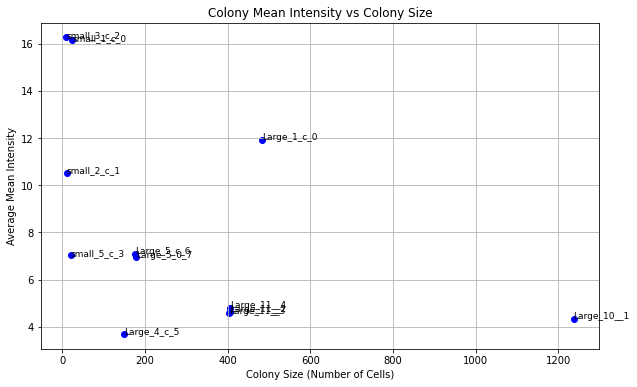

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df_cells' is the DataFrame containing the cell information with colony assignment
df_cells = combined_df
# Group by 'Colony' to calculate the mean intensity and count the number of cells in each colony
colony_stats = df_cells.groupby('NewID').agg({
    'Mean_Intensity_1': 'mean',
    'Mean_Intensity_2': 'mean',
    'Cell': 'count'  # Counting the number of cells (labels) in each colony
}).reset_index()

# Rename columns for clarity
colony_stats.rename(columns={'Mean_Intensity_1': 'Average_Mean_Intensity_1','Mean_Intensity_2': 'Average_Mean_Intensity_2', 'Cell': 'Colony_Size'}, inplace=True)

# Plotting Mean Intensity vs Colony Size
plt.figure(figsize=(10, 6))
plt.scatter( colony_stats['Colony_Size'], colony_stats['Average_Mean_Intensity_2'], color='blue')

# Annotating each point with the colony name
for i, row in colony_stats.iterrows():
    plt.text(row['Colony_Size'], row['Average_Mean_Intensity_2'], row['NewID'], fontsize=9)

plt.xlabel('Colony Size (Number of Cells)')
plt.ylabel('Average Mean Intensity')
plt.title('Colony Mean Intensity vs Colony Size')
plt.grid(True)
# Save the figure as a PDF file
# plt.savefig('scatterplot_STR_KRT14_KI67.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df_cells' is the DataFrame containing the cell information with colony assignments

# Compute the colony sizes
colony_sizes = df_cells.groupby('NewID')['Cell'].count().reset_index(name='Colony_Size')

# Merge the colony size back into the original DataFrame
df_cells = df_cells.merge(colony_sizes, on='NewID')

# Sort the DataFrame by colony size in ascending order to determine the plot order
df_cells_sorted = df_cells.sort_values(by='Colony_Size', ascending=True)

# Now, create a new column 'Colony_Order' based on the sorted colony sizes
df_cells_sorted['Colony_Order'] = df_cells_sorted['NewID'].astype('category')
df_cells_sorted['Colony_Order'].cat.set_categories(
    df_cells_sorted['NewID'].unique(), inplace=True, ordered=True
)

# Plotting the boxplots with seaborn
plt.figure(figsize=(12, 8))
ax = sns.boxplot(
    x='Colony_Order', y='Mean_Intensity_1',
    data=df_cells_sorted, order=df_cells_sorted['Colony_Order'].cat.categories#,
    #showfliers=False
)

# Improve the readability of the plot
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better visibility
plt.xlabel('Colony')
plt.ylabel('Intensity')
plt.title('Boxplot of Intensities for Each Colony Ordered by Colony Size (Smallest to Largest)')
# plt.ylim(0,30)
# plt.tight_layout()  # Adjust layout to fit everything nicely

# Save the figure as a PDF file

# plt.savefig('boxplot_STR_KI67.pdf', format='pdf', bbox_inches='tight')

plt.show()

KeyError: 'Colony_Size'

In [120]:
df_cells

,Name,Colony,Cell,Mean_Intensity_1,Median_Intensity_1,Mean_Intensity_2,Median_Intensity_2,NewID,Colony_Cell_Count,Colony_Size_x,Colony_Size_y
0,Large_11_,4,1,41.934177,45.0,6.106329,6.0,Large_11__4,407,407,407
1,Large_11_,4,2,22.150376,23.0,11.503759,11.0,Large_11__4,407,407,407
2,Large_11_,4,3,26.536585,27.0,10.139373,10.0,Large_11__4,407,407,407
3,Large_11_,4,4,26.224409,26.0,9.031496,9.0,Large_11__4,407,407,407
4,Large_11_,4,5,32.925581,31.0,10.506977,10.0,Large_11__4,407,407,407
...,...,...,...,...,...,...,...,...,...,...,...
973,small_5_c,3,17,12.029674,12.0,5.293769,5.0,small_5_c_3,21,21,21
974,small_5_c,3,18,39.514778,38.0,7.938424,8.0,small_5_c_3,21,21,21
975,small_5_c,3,19,13.429412,13.0,6.405882,6.0,small_5_c_3,21,21,21
976,small_5_c,3,20,10.243455,10.0,4.727749,5.0,small_5_c_3,21,21,21


In [118]:
# Some colonies were out of focus and imaged multiple times, these will be removed

df_cells = df_cells[df_cells['NewID'] != 'Large_11__3']
df_cells = df_cells[df_cells['NewID'] != 'Large_11__2']
df_cells = df_cells[df_cells['NewID'] != 'Large_1_c_0']
df_cells = df_cells[df_cells['NewID'] != 'Large_10__1']
df_cells

,Name,Colony,Cell,Mean_Intensity_1,Median_Intensity_1,Mean_Intensity_2,Median_Intensity_2,NewID,Colony_Cell_Count,Colony_Size
2531,Large_11_,4,1,41.934177,45.0,6.106329,6.0,Large_11__4,407,407
2532,Large_11_,4,2,22.150376,23.0,11.503759,11.0,Large_11__4,407,407
2533,Large_11_,4,3,26.536585,27.0,10.139373,10.0,Large_11__4,407,407
2534,Large_11_,4,4,26.224409,26.0,9.031496,9.0,Large_11__4,407,407
2535,Large_11_,4,5,32.925581,31.0,10.506977,10.0,Large_11__4,407,407
...,...,...,...,...,...,...,...,...,...,...
3504,small_5_c,3,17,12.029674,12.0,5.293769,5.0,small_5_c_3,21,21
3505,small_5_c,3,18,39.514778,38.0,7.938424,8.0,small_5_c_3,21,21
3506,small_5_c,3,19,13.429412,13.0,6.405882,6.0,small_5_c_3,21,21
3507,small_5_c,3,20,10.243455,10.0,4.727749,5.0,small_5_c_3,21,21


In [114]:
df_cells

,Name,Colony,Cell,Mean_Intensity_1,Median_Intensity_1,Mean_Intensity_2,Median_Intensity_2,NewID,Colony_Cell_Count,Colony_Size_x,Colony_Size_y
0,Large_11_,4,1,41.934177,45.0,6.106329,6.0,Large_11__4,407,407,407
1,Large_11_,4,2,22.150376,23.0,11.503759,11.0,Large_11__4,407,407,407
2,Large_11_,4,3,26.536585,27.0,10.139373,10.0,Large_11__4,407,407,407
3,Large_11_,4,4,26.224409,26.0,9.031496,9.0,Large_11__4,407,407,407
4,Large_11_,4,5,32.925581,31.0,10.506977,10.0,Large_11__4,407,407,407
...,...,...,...,...,...,...,...,...,...,...,...
973,small_5_c,3,17,12.029674,12.0,5.293769,5.0,small_5_c_3,21,21,21
974,small_5_c,3,18,39.514778,38.0,7.938424,8.0,small_5_c_3,21,21,21
975,small_5_c,3,19,13.429412,13.0,6.405882,6.0,small_5_c_3,21,21,21
976,small_5_c,3,20,10.243455,10.0,4.727749,5.0,small_5_c_3,21,21,21


In [104]:
# Count the number of cells per NewID (colony)
df_cells['Colony_Cell_Count'] = df_cells.groupby('NewID')['NewID'].transform('count')
df_cells

,Name,Colony,Cell,Mean_Intensity_1,Median_Intensity_1,Mean_Intensity_2,Median_Intensity_2,NewID,Colony_Cell_Count
0,Large_1_c,0,1,69.715736,71.0,17.822335,18.0,Large_1_c_0,483
1,Large_1_c,0,2,66.581731,68.0,19.024038,19.0,Large_1_c_0,483
2,Large_1_c,0,3,35.042194,36.0,11.949367,12.0,Large_1_c_0,483
3,Large_1_c,0,4,51.081395,52.0,17.197674,17.0,Large_1_c_0,483
4,Large_1_c,0,5,45.391111,45.0,14.822222,15.0,Large_1_c_0,483
...,...,...,...,...,...,...,...,...,...
3504,small_5_c,3,17,12.029674,12.0,5.293769,5.0,small_5_c_3,21
3505,small_5_c,3,18,39.514778,38.0,7.938424,8.0,small_5_c_3,21
3506,small_5_c,3,19,13.429412,13.0,6.405882,6.0,small_5_c_3,21
3507,small_5_c,3,20,10.243455,10.0,4.727749,5.0,small_5_c_3,21


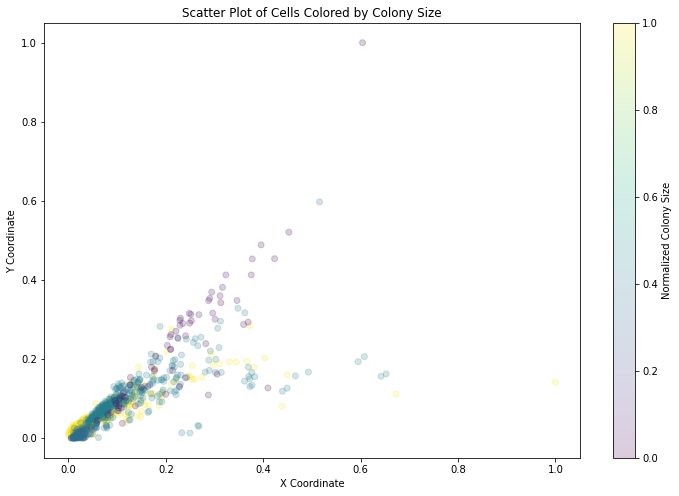

In [121]:
# Normalize the colony size for color mapping
norm_colony_size = (df_cells['Colony_Cell_Count'] - df_cells['Colony_Cell_Count'].min()) / (df_cells['Colony_Cell_Count'].max() - df_cells['Colony_Cell_Count'].min())

# Normalize the 'Mean_Intensity' column
norm_M1 = (df_cells['Mean_Intensity_1'] - df_cells['Mean_Intensity_1'].min()) / (df_cells['Mean_Intensity_1'].max() - df_cells['Mean_Intensity_1'].min())
norm_M2 = (df_cells['Mean_Intensity_2'] - df_cells['Mean_Intensity_2'].min()) / (df_cells['Mean_Intensity_2'].max() - df_cells['Mean_Intensity_2'].min())


# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(
    norm_M1,  # Replace with your actual x-coordinate column
    norm_M2,  # Replace with your actual y-coordinate column
    c=norm_colony_size,  # This will be the color based on the normalized colony size
    cmap='viridis',  # This is a color map, you can choose any you like
    alpha=0.2  # Adjusts the transparency of the points
)

# Create a color bar
plt.colorbar(label='Normalized Colony Size')

# Improve the readability of the plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Cells Colored by Colony Size')

# Show the plot
plt.show()

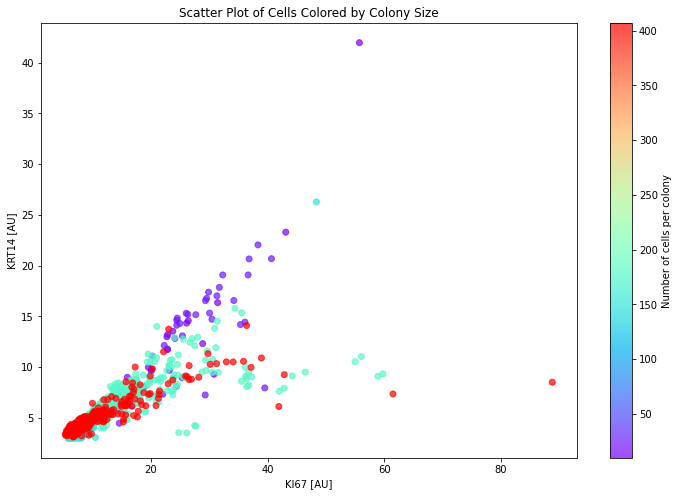

In [125]:
output_path = '/Users/raul/Documents/GitHub/EsophagealCloneVariability/RAR058/plot/'

# Sort the DataFrame by 'Colony_Size' in descending order so that larger colonies get plotted first
df_cells_sorted = df_cells.sort_values('Colony_Cell_Count', ascending=True)


# Normalize the colony size for color mapping
norm_colony_size = (df_cells_sorted['Colony_Cell_Count'] - df_cells_sorted['Colony_Cell_Count'].min()) / (df_cells_sorted['Colony_Cell_Count'].max() - df_cells_sorted['Colony_Cell_Count'].min())

# Create a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df_cells_sorted['Mean_Intensity_1'],  # Replace with your actual x-coordinate column
    df_cells_sorted['Mean_Intensity_2'],  # Replace with your actual y-coordinate column
    c= df_cells_sorted['Colony_Cell_Count'],  # This will be the color based on the normalized colony size
    cmap='rainbow',  # This is a color map, you can choose any you like
    alpha=.7  # Adjusts the transparency of the points
    #edgecolor='w',  # Adds a white edge to each point, if desired for better visibility
)

# Create a color bar
plt.colorbar(scatter, label='Number of cells per colony')

# Improve the readability of the plot
plt.xlabel('KI67 [AU]')
plt.ylabel('KRT14 [AU]')
plt.title('Scatter Plot of Cells Colored by Colony Size')

# Save the figure as a PDF file
plt.savefig(output_path + 'scatterplot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()



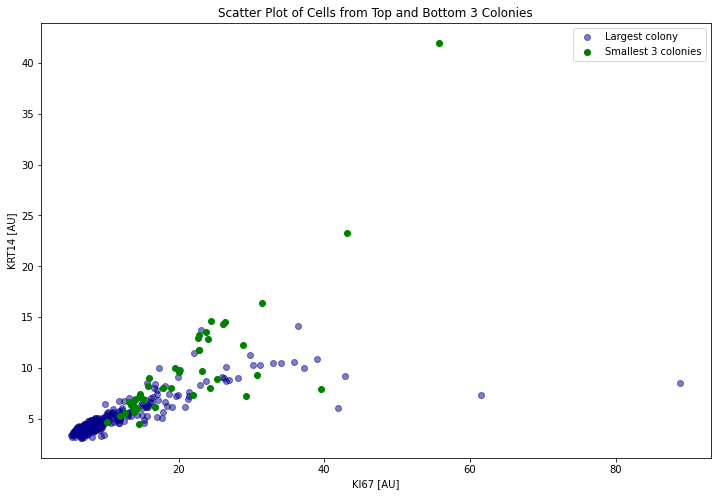

In [124]:
# Calculate the sizes of each colony
colony_sizes = df_cells.groupby('NewID').size().reset_index(name='Colony_Cell_Count')

# Find the top three and bottom three colonies
top_three_colonies = colony_sizes.nlargest(1, 'Colony_Cell_Count')['NewID']
bottom_three_colonies = colony_sizes.nsmallest(3, 'Colony_Cell_Count')['NewID']

# Filter the DataFrame to include only cells from these six colonies
top_bottom_cells = df_cells[df_cells['NewID'].isin(top_three_colonies) | df_cells['NewID'].isin(bottom_three_colonies)]

# Plot the cells from the top and bottom three colonies
plt.figure(figsize=(12, 8))

# Plot top three colonies
for colony in top_three_colonies:
    colony_cells = top_bottom_cells[top_bottom_cells['NewID'] == colony]
    plt.scatter(
        colony_cells['Mean_Intensity_1'],  # Replace with your actual x-coordinate column
        colony_cells['Mean_Intensity_2'],  # Replace with your actual y-coordinate column
        label=f'Colony {colony} (Top 3)',
        alpha=0.5,
        c='darkblue'
    )

# Plot bottom three colonies
for colony in bottom_three_colonies:
    colony_cells = top_bottom_cells[top_bottom_cells['NewID'] == colony]
    plt.scatter(
        colony_cells['Mean_Intensity_1'],  # Replace with your actual x-coordinate column
        colony_cells['Mean_Intensity_2'],  # Replace with your actual y-coordinate column
        label=f'Colony {colony} (Bottom 3)',
        alpha=1,
        c='green'
    )

# Improve the readability of the plot
plt.xlabel('KI67 [AU]')
plt.ylabel('KRT14 [AU]')
plt.title('Scatter Plot of Cells from Top and Bottom 3 Colonies')
plt.legend(['Largest colony','Smallest 3 colonies'])


# Save the figure as a PDF file
# plt.savefig('scatterplot_top1_bot3.pdf', format='pdf', bbox_inches='tight')

plt.show()